In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import datetime
from geopy import distance
from sklearn.preprocessing import OneHotEncoder
import json


In [2]:
path = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/datasets_penguins'
def load_penguins(path):
    files = os.listdir(path)
    df_original = pd.concat([pd.read_csv(path + '/' + file) for file in files])
    df = df_original.drop(columns=['equinox', 'original_track_id']).reset_index(drop=True)
    return df

In [5]:
df = load_penguins(path)

In [6]:
# Test if there is more than one track_id bird_id pair per bird_id
print(df.groupby(['bird_id', 'track_id']).size().reset_index().groupby('bird_id').size().max())


4


--> use track_id

In [7]:
# Replace dd-mm-yyyy or yyyy-mm-dd with dd/mm/yyyy
def date_formatting(df):
    date_target_format = '%d/%m/%Y'

    for i in range(len(df)):
        # check if format is YYYY-MM-DD
        if '-' in df.at[i, 'date_gmt'] and datetime.strptime(df.at[i, 'date_gmt'], '%Y-%m-%d'): 
            df.at[i, 'date_gmt'] = datetime.strptime(df.at[i, 'date_gmt'], '%Y-%m-%d').strftime(date_target_format)
        # check if format is DD-MM-YYYY
        elif '-' in df.at[i, 'date_gmt'] and datetime.strptime(df.at[i, 'date_gmt'], '%d-%m-%Y'):
            df.at[i, 'date_gmt'] = datetime.strptime(df.at[i, 'date_gmt'], '%d-%m-%Y').strftime(date_target_format)
    
    # Create datetime column
    df['datetime'] = df['date_gmt'].astype(str) + ' ' + df['time_gmt'].astype(str)
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')

    return df

In [8]:
df = date_formatting(df)

In [9]:
# Sort dataframe in date/time per bird and trip
df = df.sort_values(['track_id', 'date_gmt', 'time_gmt']).reset_index(drop=True)

In [10]:
print(len(df['datetime'].unique()), len(df['datetime']))
print(len(df['track_id'].unique()), len(df['track_id']))

241925 415643
981 415643


In [11]:
# Check for duplicated datetime values for each track_id

def measurement_duplicates(df):
    #datetime_format = '%d/%m/%Y %H:%M:%S'
    duplicated_datetimes = []
    for i in range(1, len(df)):
        if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
            timestamp_1 = df.at[i-1, 'datetime']
            timestamp_2 = df.at[i, 'datetime']
            if timestamp_1 == timestamp_2:
                duplicated_datetimes.append(i)
    print(len(duplicated_datetimes))    


In [12]:
measurement_duplicates(df)

49578


In [13]:
# Löschen der Duplikate
df = df.drop_duplicates(subset=['track_id', 'datetime']).reset_index(drop=True)

In [14]:
df = df.sort_values(['track_id', 'datetime']).reset_index(drop=True)

In [15]:
df['pos_bird'] = list(zip(df['latitude'], df['longitude']))
df['pos_colony'] = list(zip(df['lat_colony'], df['lon_colony']))

In [16]:
# breed_status is redundant

print(df['breed_stage'].nunique(), df['breed_status'].nunique())
print(df['breed_stage'].unique(), df['breed_status'].unique())
df = df.drop(columns='breed_status')

7 2
['non-breeding' 'chick-rearing' 'brood-guard' 'creche' 'incubation'
 'breeding' 'winter'] ['non-breeding' 'breeding']


## Features

In [17]:
# Calculate geodesic distance between bird and colony
# Elliposid used: WGS-84  

df['km_to_colony'] = df.apply(lambda row: distance.distance(row['pos_bird'], row['pos_colony']).km, axis=1)

In [18]:
# Below calculation is similar to performing weighted average

def mean_distance(df):
    # Calculate mean distance and std per penguin
    mean_distance_per_penguin = df.groupby('track_id')['km_to_colony'].mean()
    std_distance_per_penguin = df.groupby('track_id')['km_to_colony'].std()

    # Average over mean distances
    mean_distance_overall = mean_distance_per_penguin.mean()
    std_distance_overall = mean_distance_per_penguin.std()
    return mean_distance_overall, std_distance_overall

In [19]:
mean_distance, std_distance = mean_distance(df) 

In [20]:
# Position relative to colony
def calculate_relative_position(df):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']

    for i in range(len(df)):
        delta_lat = df.at[i,'latitude'] - df.at[i, 'lat_colony']
        delta_lon = df.at[i, 'longitude'] - df.at[i, 'lon_colony']
        degrees_temp = math.atan2(delta_lat, delta_lon)/math.pi*180
        if degrees_temp < 0:
            degrees_final = degrees_temp + 360
        else:
            degrees_final = degrees_temp

        lookup = round(degrees_final/45) # because of 8 possible directions

        df.at[i, 'relative_position'] = directions[lookup]
        
    return df

In [21]:
df = calculate_relative_position(df)

In [22]:
# Direction of travel
# If bird_id changes: relative position to colony
# If bird_id stays the same: calculate direction of travel

def direction_of_travel(df):
    
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    df.at[0, 'direction_of_travel'] = df.at[0, 'relative_position']

    for i in range(1, len(df)):
        if df.at[i, 'track_id'] != df.at[i-1,'track_id']:
            df.at[i, 'direction_of_travel'] = df.at[i, 'relative_position']
        else:
            delta_lat = delta_lat = df.iloc[i]['latitude'] - df.iloc[i-1]['latitude']
            delta_lon = df.iloc[i]['longitude'] - df.iloc[i-1]['longitude']
            degrees_temp = math.atan2(delta_lat, delta_lon)/math.pi*180

            if degrees_temp < 0:
                degrees_final = degrees_temp + 360
            else:
                degrees_final = degrees_temp

            lookup = round(degrees_final/45)

            df.at[i, 'direction_of_travel'] = directions[lookup]
    return df

In [23]:
df = direction_of_travel(df)

In [24]:
# Distance travelled between each measure (might define previous steps as formulas and apply them directly)
def distance_since_last_measure(df):
    df['km_since_last_measure'] = 0
    df['km_since_last_measure'] = df['km_since_last_measure'].astype(float)
    for i in range(1, len(df)):
        if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
            df.at[i, 'km_since_last_measure'] = distance.distance(df.at[i,'pos_bird'], df.at[i-1,'pos_bird']).km
        else:
            df.at[i, 'km_since_last_measure'] = 0
    return df

In [25]:
df = distance_since_last_measure(df)

In [26]:
# Distace North, East, South, West

def distance_direction(df):

    df['delta_km_north'] = 0
    df['delta_km_north'] = df['delta_km_north'].astype(float)
    df['delta_km_south'] = 0
    df['delta_km_south'] = df['delta_km_south'].astype(float)

    for i in range(1, len(df)):
        start = (0, df.at[i-1, 'longitude'])
        finish = (0, df.at[i, 'longitude'])
        delta = distance.distance(start, finish).km
        if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
            if delta > 0:
                df.at[i, 'delta_km_north'] = delta
            if delta < 0:
                df.at[i, 'delta_km_south'] = delta
        else:
            df.at[i, 'delta_km_north'] = 0
            


    df['delta_km_east'] = 0
    df['delta_km_east'] = df['delta_km_east'].astype(float)
    df['delta_km_west'] = 0
    df['delta_km_west'] = df['delta_km_west'].astype(float)

    for i in range(1, len(df)):
        start = (df.at[i-1, 'latitude'], 0)
        finish = (df.at[i, 'latitude'], 0)
        delta = distance.distance(start, finish).km
        if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
            if delta > 0:
                df.at[i, 'delta_km_east'] = delta
            elif delta < 0:
                df.at[i, 'delta_km_west'] = delta
        else:
            df.at[i, 'delta_km_east'] = 0

    return df

In [27]:
df = distance_direction(df)

In [28]:
# Time difference betweeen measures in minutes(time_gmt = hh:mm:ss, date_gmt = dd/mm/yyyy)

def time_difference(df):
    df['minutes_since_last_measure'] = 0
    df['minutes_since_last_measure'] = df['minutes_since_last_measure'].astype(float)
    for i in range(1, len(df)):
        if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
            timestamp_1 = df.at[i-1, 'datetime']
            timestamp_2 = df.at[i, 'datetime']
            df.at[i,'minutes_since_last_measure'] = (timestamp_2 - timestamp_1).total_seconds()/60
        else:
            df.at[i, 'minutes_since_last_measure'] = 0
    return df

In [29]:
df = time_difference(df)

In [30]:
print(df['minutes_since_last_measure'].describe())
# Max is around 80 days (double-checked with excel)

count    366065.000000
mean         82.864815
std        1136.873220
min           0.000000
25%           4.883333
50%          15.000000
75%          40.000000
max      126200.000000
Name: minutes_since_last_measure, dtype: float64


## BIN

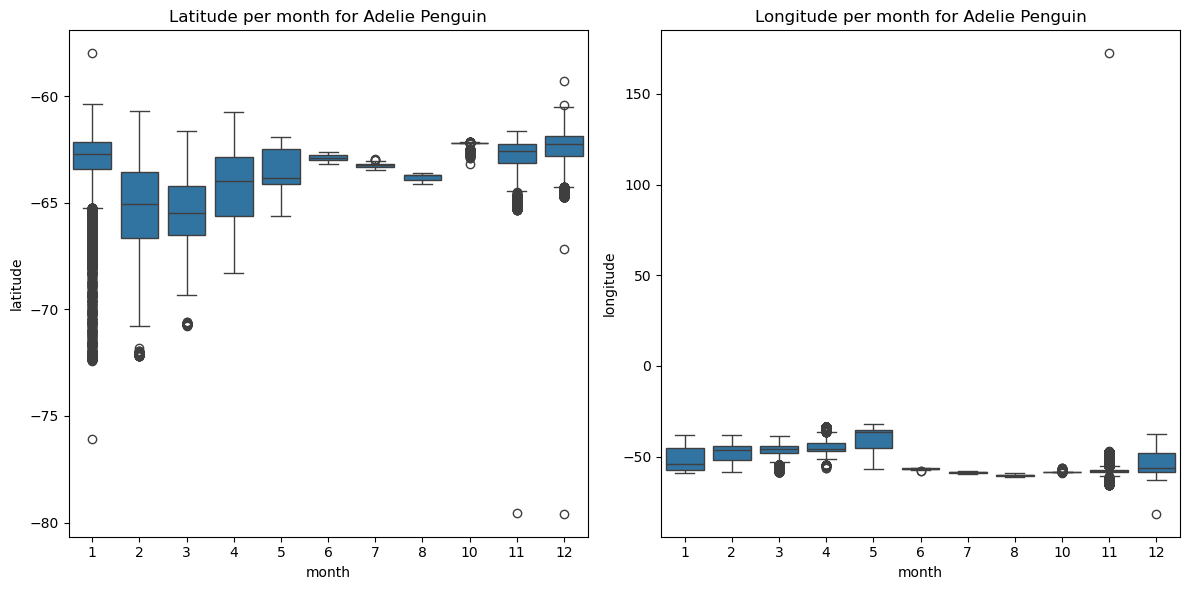

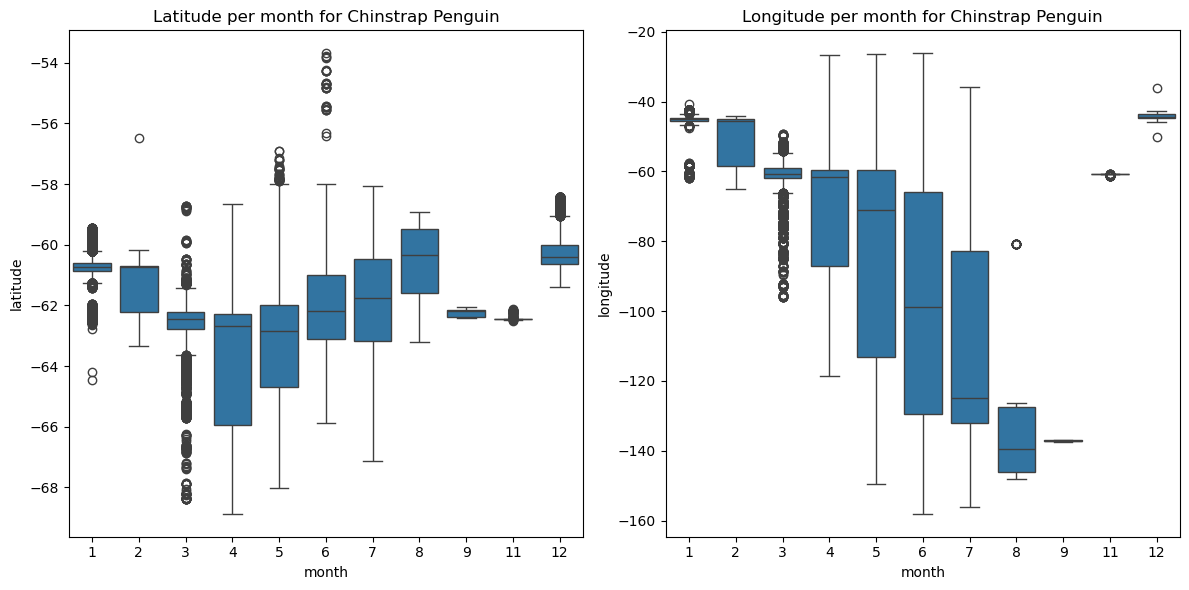

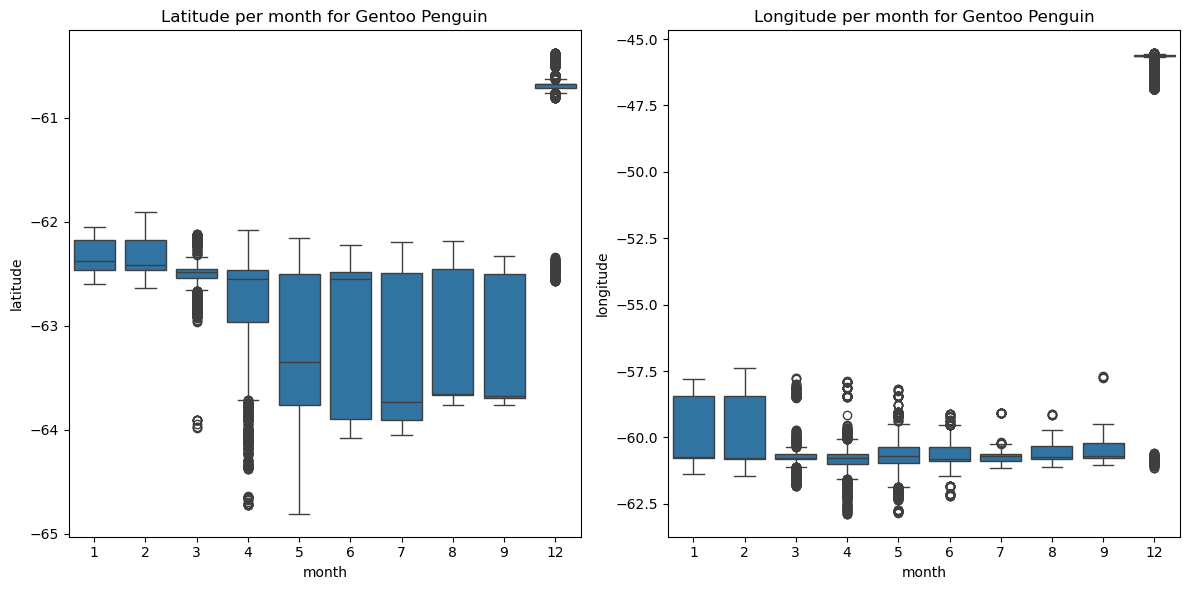

In [34]:
# Plot coordinates of different species per month (no matter the year)

df['month'] = df['date_gmt'].str.split('/').str[1]
df['month'] = df['month'].astype(int)
# create one plot per species, with moth on x-axis and latitude on y-axis and one per species with month on x-axis and longitude on y-axis
species = df['common_name'].unique()

months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(x='month', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per month for ' + specie)
    sns.boxplot(x='month', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per month for ' + specie)
    plt.tight_layout()
    plt.show()


In [35]:
titles = {'siconc': 'Sea Ice Concentration', 'rsn': 'Snow Density', 'sst': 'Sea Surface Temperature', 'sd': 'Snow Depth', 't2m': '2m Temperature', 'tp': 'Total Precipitation', 'avg_smr': 'Average Snowmelt Rate'}

column = df['km_to_colony']

def plot_monthly(df, column, deg):
    df = df.copy()
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    # only keep values from years 1996, 2000, 2004, 2008, 2012, 2016
    df = df[df['year'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])]

    plt.figure(figsize=(12, 3))
    
    # for each column, use only rows that dont have zero values
    df = df[df[column] != 0]

    #scatter = plt.scatter(df['month'], df[column], c = 'black')
    scatter = plt.scatter(df['month'], df[column], 
                        c=df['year'], cmap='viridis')

    # Add colorbar
    plt.colorbar(scatter, label='Year')

    plt.xlabel('month')
    #plt.title(title)
    plt.tight_layout()
    plt.show()

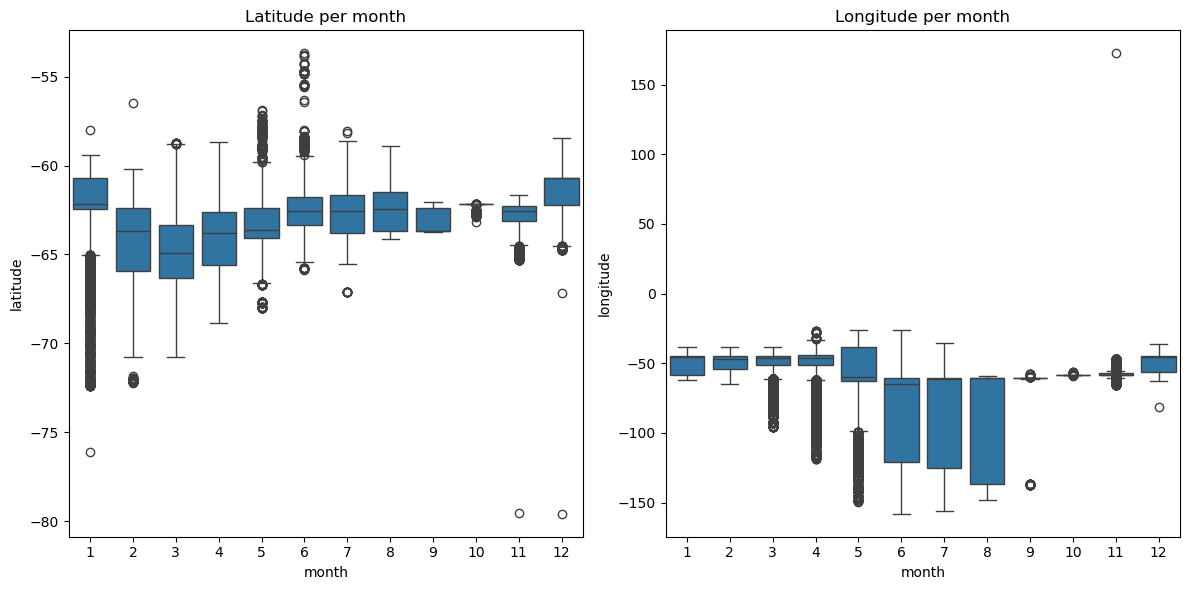

In [37]:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='month', y='latitude', data=df, ax=ax[0])
ax[0].set_title('Latitude per month')
sns.boxplot(x='month', y='longitude', data=df, ax=ax[1])
ax[1].set_title('Longitude per month')
plt.tight_layout()
plt.show()

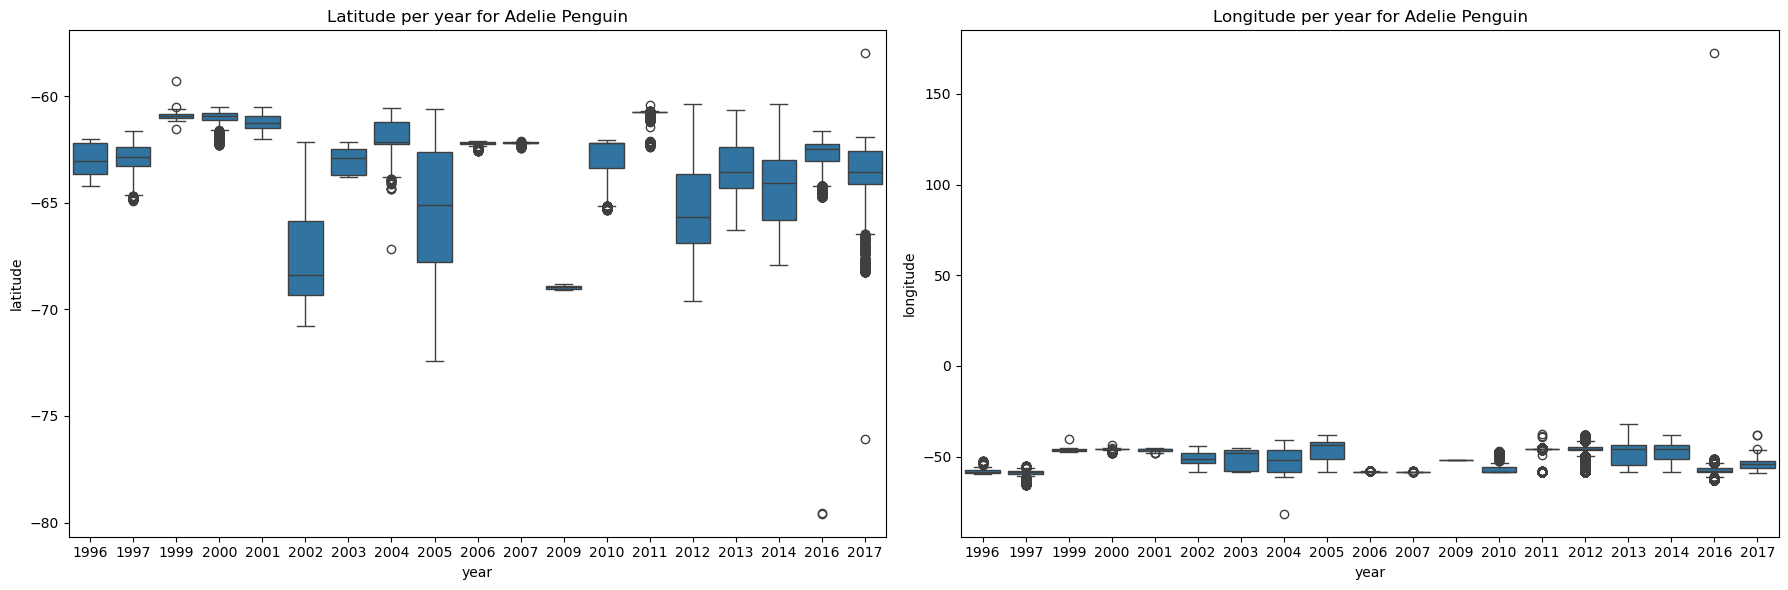

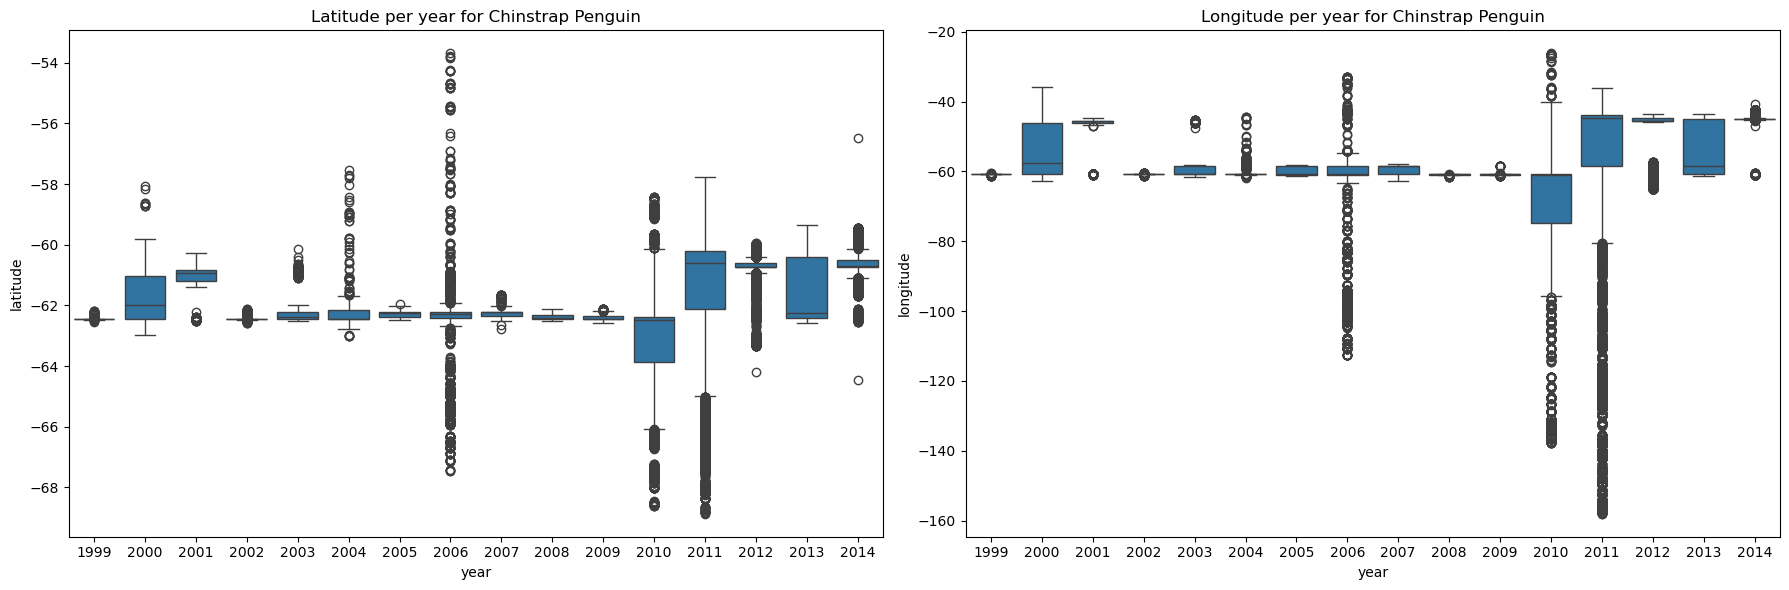

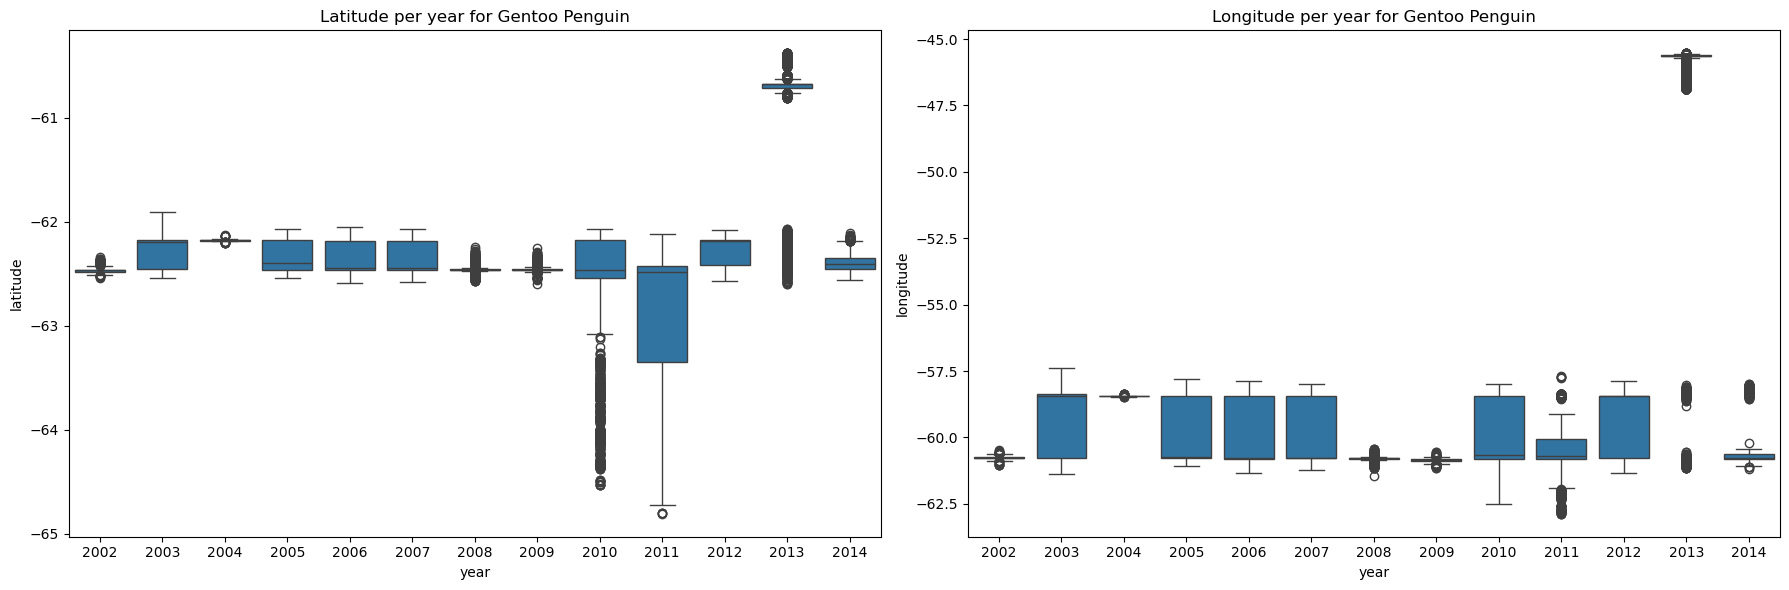

In [38]:
df['year'] = df['date_gmt'].str.split('/').str[2]
df['year'] = df['year'].astype(int)

for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.boxplot(x='year', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per year for ' + specie)
    sns.boxplot(x='year', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per year for ' + specie)
    plt.tight_layout()
    plt.show()

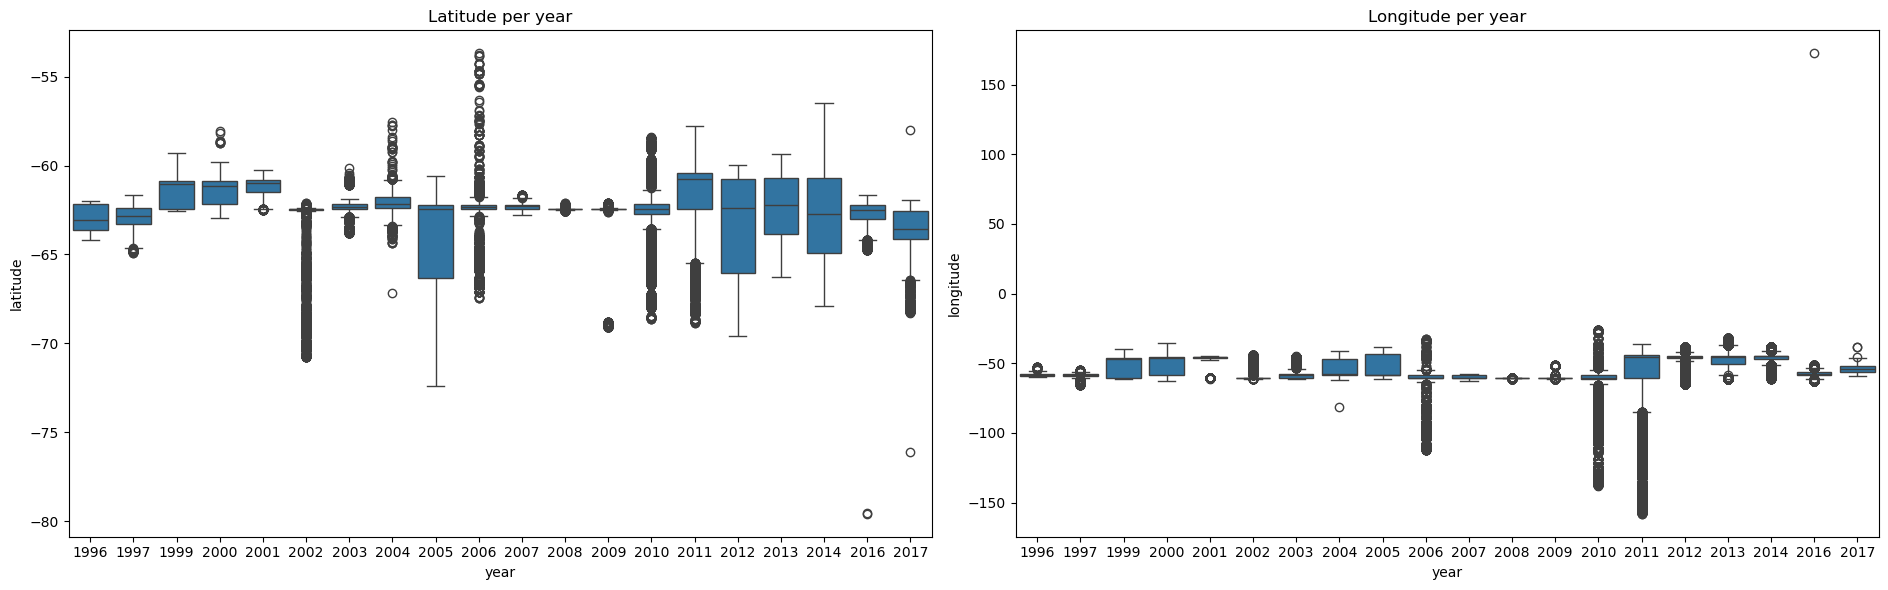

In [39]:
# plots in general
fig, ax = plt.subplots(1, 2, figsize = (19, 6))
sns.boxplot(x='year', y='latitude', data = df, ax=ax[0])
ax[0].set_title('Latitude per year')
sns.boxplot(x='year', y='longitude', data = df, ax=ax[1])
ax[1].set_title('Longitude per year')
plt.tight_layout()
plt.show()

# x axis label anpassen

In [41]:
# One Hot Encoding:
categorical_cols = ['breed_stage', 'relative_position', 'direction_of_travel']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])

one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_cols))

df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_cols, axis=1)

df = df_encoded

In [42]:
# save df to csv and store in zip file

path_new = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/data'
#df_encoded.to_csv(path_new + '/' + 'penguins_cleaned.csv', index=False, compression='zip')

df.to_csv(path_new + '/' +'penguins_cleaned.zip', compression={'method': 'zip', 'archive_name': 'penguins_cleaned.csv'}, index=False)

In [1]:
print(df.columns)

NameError: name 'df' is not defined

# Create new dataframe that averages each day per track id and repeat above steps

In [43]:
# Average time stamps to match weather: One per day
# Try to get a distribution for those accumulated time stamps --> one for each day per unique_id

def average_per_day(df):

    df['date_gmt'] = pd.to_datetime(df['date_gmt'], format='%d/%m/%Y')

    aggregate_cols = ['latitude', 'longitude', 'lat_colony', 'lon_colony', 'km_to_colony', 'km_since_last_measure', 
                        'delta_km_north', 'delta_km_south', 'delta_km_east', 
                        'delta_km_west', 'minutes_since_last_measure']

    # Calculate mean
    df_mean = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].mean().reset_index()
    df_mean.columns = ['track_id', 'date_gmt'] + [f'{col}_mean' for col in aggregate_cols]

    # Calculate standard deviation
    # Entscheidung ob ddof = 1 (sample) oder ddof = 0 (population) -->Tradeoff
    df_std = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].std(ddof=0).reset_index()
    df_std.columns = ['track_id', 'date_gmt'] + [f'{col}_std' for col in aggregate_cols]

    #df_min
    df_min = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].min().reset_index()
    df_min.columns = ['track_id', 'date_gmt'] + [f'{col}_min' for col in aggregate_cols]

    #df_max
    df_max = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].max().reset_index()
    df_max.columns = ['track_id', 'date_gmt'] + [f'{col}_max' for col in aggregate_cols]

    # Merge dataframes
    df_penguins_pt1 = pd.merge(df_mean, df_std, on=['track_id', 'date_gmt'])

    df_penguins_pt2 = pd.merge(df_min, df_max, on=['track_id', 'date_gmt'])

    df_penguins_final = pd.merge(df_penguins_pt1, df_penguins_pt2, on=['track_id', 'date_gmt'])

    # Lookup operation to add 'common_name', 'site_name','colony_name' back based on track id
    df_subset = df.drop_duplicates(subset='track_id')
    add_back = ['common_name', 'site_name','colony_name']
    for column in add_back:
        df_penguins_final[column] = df_penguins_final['track_id'].map(df_subset.set_index('track_id')[column])

    return df_penguins_final

In [44]:
df_penguins_final = average_per_day(df)
df_penguins_final.to_csv(path_new + '/' +'penguins_final.zip', compression={'method': 'zip', 'archive_name': 'penguins_final.csv'})

## Save unique dates as JSON to access in API call

In [ ]:
# transform date back to string

def save_to_json(df, path):

    df['date_gmt'] = df['date_gmt'].astype(str)

    # extract each unique combination of year, month and day in a dictionary
    unique_dates = df['date_gmt'].unique()
    unique_dates_dict = {}

    # suppose preprocessing of date already happened
    for date in unique_dates:
        year = date.split('-')[0]
        month = date.split('-')[1]
        day = date.split('-')[2]
        unique_dates_dict[date] = {'year': year, 'month': month, 'day': day}


    #df_encoded.to_csv(path_json + '/' + 'penguins_cleaned.csv', index=False, compression='zip')
    json.dump(unique_dates_dict, open(path + '/' + 'unique_dates_dict.json', 'w'))
    print('JSON file saved to ' + path)


In [ ]:
path_json = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/era5_datasets'
save_to_json(df_penguins_final, path_json)

# Get insights into the penguins behaviour

In [51]:
# calculate spread for different species

def spread_species(df, species):
    for specie in species:
        print(f'\n========{specie}========')
        for colony in df[df['common_name'] == specie]['colony_name'].unique():
            df_specie = df(df['common_name'] == specie) & (df'colony_name'] == colony)]
            spread = df_specie['km_to_colony_mean'].std(ddof=1)
            print(colony, spread)

Adelie Penguin
King George Island 156.8922767009632
Hope Bay 204.50053560976153
Powell Island/Peng colony 241.1019912032257
Signy Island/Gourlay 234.41072806291984
Signy Island/North Point 397.9617597992179
Admiralty Bay 252.13850471057341
Chinstrap Penguin
Laurie Island/Cape Geddes 33.81119977181794
Signy Island/Gourlay 15.947249101383012
Powell Island/Peng colony 20.863095171907652
Admiralty Bay 191.11673222630228
Cape Shirreff 898.6426014496931
Gentoo Penguin
Signy Island/North Point 14.226600107963902
Admiralty Bay 9.8093438462616
Cape Shirreff 48.9572812598909


In [ ]:
species = df['common_name'].unique()

spread_species(df_penguins_final, species)

In [52]:
# Mean deviation
# MAYBE IN PERCENT?
def calculte_mean_deviation(df):
    species = df['common_name'].unique()
    for specie in species:
        print(f'\n========{specie}========')
        for colony in df[df['common_name'] == specie]['colony_name'].unique():
            df_specie = df[(df['common_name'] == specie) & (df['colony_name'] == colony)]
            
            # Calculate mean deviation manually
            mean_value = df_specie['km_to_colony_mean'].mean()
            mean_deviation = (df_specie['km_to_colony_mean'] - mean_value).abs().mean()
            print(colony, mean_deviation)

In [53]:
calculte_mean_deviation(df_penguins_final)

Adelie Penguin
King George Island 129.4704820208191
Hope Bay 164.31657218913702
Powell Island/Peng colony 188.5177415557273
Signy Island/Gourlay 200.64823394539997
Signy Island/North Point 340.630021992136
Admiralty Bay 187.6252134675522
Chinstrap Penguin
Laurie Island/Cape Geddes 19.193426327121703
Signy Island/Gourlay 12.324104237789548
Powell Island/Peng colony 12.005098504707792
Admiralty Bay 96.47090182991843
Cape Shirreff 571.9082535242949
Gentoo Penguin
Signy Island/North Point 8.846322623042843
Admiralty Bay 6.105893753653458
Cape Shirreff 32.132810331351685


# do it in time series perspective


In [55]:
# add year back for calculation
# extract each unique combination of year, month and day in a dictionary
unique_dates = df_penguins_final['date_gmt'].unique()
for date in unique_dates:
    year = date.split('-')[0]
    df_penguins_final.loc[df_penguins_final['date_gmt'] == date, 'year'] = year
df_penguins_final = df_penguins_final.sort_values('year').reset_index(drop=True)

In [56]:
# print number of oberverations per year and species
species = df_penguins_final['common_name'].unique()
years = df_penguins_final['year'].unique()
for specie in species:
    for year in years:
        print(specie, f'{year}:', len(df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['year'] == year)]))

Adelie Penguin 1996: 46
Adelie Penguin 1997: 198
Adelie Penguin 1999: 34
Adelie Penguin 2000: 75
Adelie Penguin 2001: 19
Adelie Penguin 2002: 77
Adelie Penguin 2003: 69
Adelie Penguin 2004: 212
Adelie Penguin 2005: 295
Adelie Penguin 2006: 41
Adelie Penguin 2007: 19
Adelie Penguin 2008: 0
Adelie Penguin 2009: 10
Adelie Penguin 2010: 122
Adelie Penguin 2011: 44
Adelie Penguin 2012: 1081
Adelie Penguin 2013: 720
Adelie Penguin 2014: 766
Adelie Penguin 2016: 1265
Adelie Penguin 2017: 937
Chinstrap Penguin 1996: 0
Chinstrap Penguin 1997: 0
Chinstrap Penguin 1999: 46
Chinstrap Penguin 2000: 273
Chinstrap Penguin 2001: 121
Chinstrap Penguin 2002: 155
Chinstrap Penguin 2003: 177
Chinstrap Penguin 2004: 133
Chinstrap Penguin 2005: 124
Chinstrap Penguin 2006: 495
Chinstrap Penguin 2007: 226
Chinstrap Penguin 2008: 64
Chinstrap Penguin 2009: 155
Chinstrap Penguin 2010: 503
Chinstrap Penguin 2011: 839
Chinstrap Penguin 2012: 465
Chinstrap Penguin 2013: 147
Chinstrap Penguin 2014: 413
Chinstrap Pe

Could be beneficial to filter out years with less than 30 obs.
Also for interpretability, from 2012 on,  it is mainly adelie penguins

In [57]:
# filter out years with less than 30 observations?
df_penguins_final = df_penguins_final.groupby(['year', 'colony_name']).filter(lambda x: len(x) > 30).reset_index(drop=True)

# filter out obeservations with more than 1 day between measures
df_penguins_final = df_penguins_final[df_penguins_final['minutes_since_last_measure_mean'] <= 1440].reset_index(drop=True)

In [58]:
# for all penguins independent of species or colony:
mean_deviation_results = []
for year in df_penguins_final['year'].unique():
    mean_value = df_penguins_final[df_penguins_final['year'] == year]['km_to_colony_mean'].mean()
    # mean_deviation = (df_penguins_final[df_penguins_final['year'] == year]['km_to_colony_mean'] - mean_value).abs().mean()
    mean_deviation_results.append({'year': year, 'mean distance': mean_value})
    print(year, mean_value)

# Convert results to DataFrame
results_df = pd.DataFrame(mean_deviation_results)



1996 119.42293188268323
1997 102.85551049942231
1999 23.958187256059905
2000 66.38570436225233
2001 23.6736847259847
2002 197.1576421747534
2003 59.702395135625764
2004 76.61335333327216
2005 260.2343362689401
2006 169.24734865355992
2007 8.034396409602627
2008 6.394029345248861
2009 8.981478125978368
2010 235.80064627202754
2011 408.42695013264296
2012 303.42170347470363
2013 203.52449810984547
2014 245.80356136641353
2016 102.49050039475866
2017 244.54171955523043


In [ ]:
# for each species and colony

# TRY TO STANDARDIZE THE DISTANCES

species = df['common_name'].unique()
years = df_penguins_final['year'].unique()
results_species_colony = []
for year in years:
    for specie in species:
        for colony in df[df['common_name'] == specie]['colony_name'].unique():
            df_specie = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['colony_name'] == colony) & (df_penguins_final['year'] == year)]
            # Calculate mean deviation manually
            mean_value = df_specie['km_to_colony_mean'].mean()
            # mean_deviation = (df_specie['km_to_colony_mean'] - mean_value).abs().mean()
            results_species_colony.append({'year': year, 'species': specie, 'colony': colony, 'mean distance': mean_value})

In [10]:
# plot the results in 3 different plots, one for each species
results_species_colony = pd.DataFrame(results_species_colony)

for specie in species:
    results_specie = results_species_colony[results_species_colony['species'] == specie]
    plt.figure(figsize=(12, 6))
    for colony in results_specie['colony'].unique():
        colony_data = results_specie[results_specie['colony'] == colony]
        plt.scatter(colony_data['year'], colony_data['mean distance'], label=colony)
    plt.xlabel('Year')
    plt.ylabel('Mean distance in km')
    plt.title(f'Mean distance Over Years for {specie}')
    plt.legend(title='Colony')
    plt.grid(False)
    plt.show()

NameError: name 'results_species_colony' is not defined

In [126]:
# Convert years to strings
available_years = [str(x) for x in range(1996, 2018)]
available_years = np.array(available_years)

# Ensure the 'year' column in df_penguins_final is of type string
df_penguins_final['year'] = df_penguins_final['year'].astype(str)

# For each species and colony, see if there is data for more than 10 years
species = df['common_name'].unique()
results_species_colony = []

for specie in species:
    for colony in df[df['common_name'] == specie]['colony_name'].unique():
        years_with_data = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['colony_name'] == colony)]['year'].unique()
        if len(years_with_data) >= 8:
            print(f'{specie} , {colony} has data for more than 5 years')
        else:
            print('--')

--
--
--
--
--
Adelie Penguin , Admiralty Bay has data for more than 5 years
--
--
--
Chinstrap Penguin , Admiralty Bay has data for more than 5 years
Chinstrap Penguin , Cape Shirreff has data for more than 5 years
--
Gentoo Penguin , Admiralty Bay has data for more than 5 years
Gentoo Penguin , Cape Shirreff has data for more than 5 years


## Some more EDA

In [111]:
# noch nach specie filtern
species = df['common_name'].unique()

def plot_yearly_species(df, deg, species):
    df['date_gmt'] = pd.to_datetime(df['date_gmt'])
    df['year'] = df['date_gmt'].dt.year
    df['month'] = df['date_gmt'].dt.month
    for specie in species:
        plt.figure(figsize=(12, 3))
        
        # Filter the dataframe for the current species
        df_species = df[df['common_name'] == specie].copy()  # Use .copy() to avoid modifying df
        # Group by year and compute mean of km_to_colony
        df_species = df_species.groupby('year', as_index=False)['km_to_colony'].mean()
        title = specie

        plt.scatter(df_species['year'], df_species['km_to_colony'], c='black')


        if len(df_species) > deg:  # Ensure enough points for regression
            z = np.polyfit(df_species['year'], df_species['km_to_colony'], deg)
            p = np.poly1d(z)
            plt.plot(df_species['year'], p(df_species['year']), linestyle="-", c='red', linewidth=0.8)


        plt.xlabel('Year')
        plt.title(title)
        plt.tight_layout()
        plt.show()


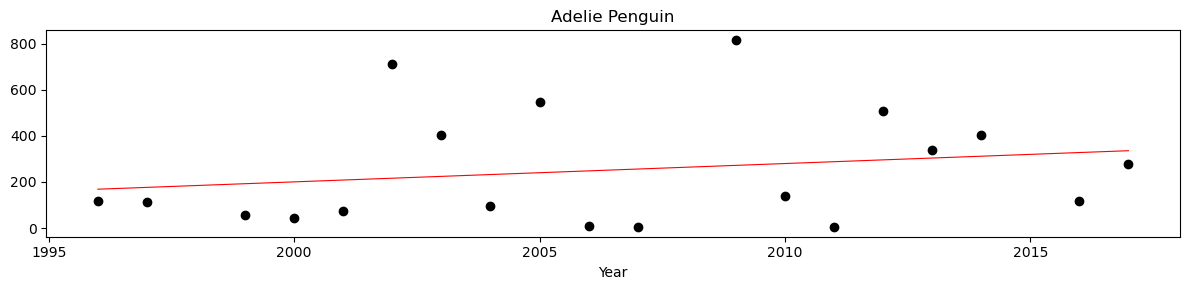

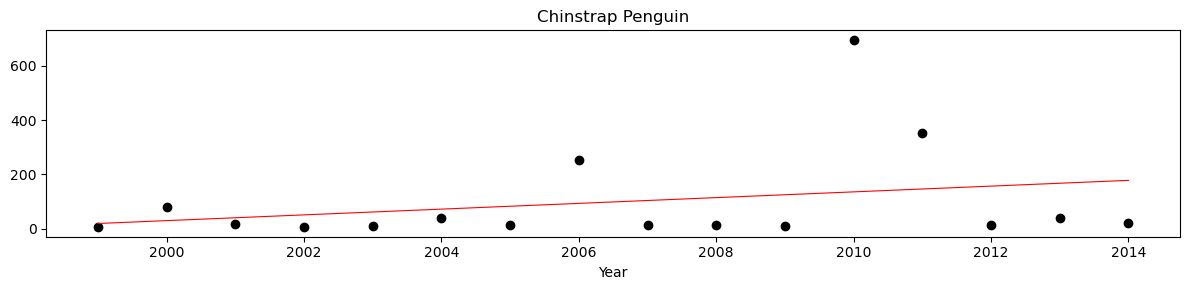

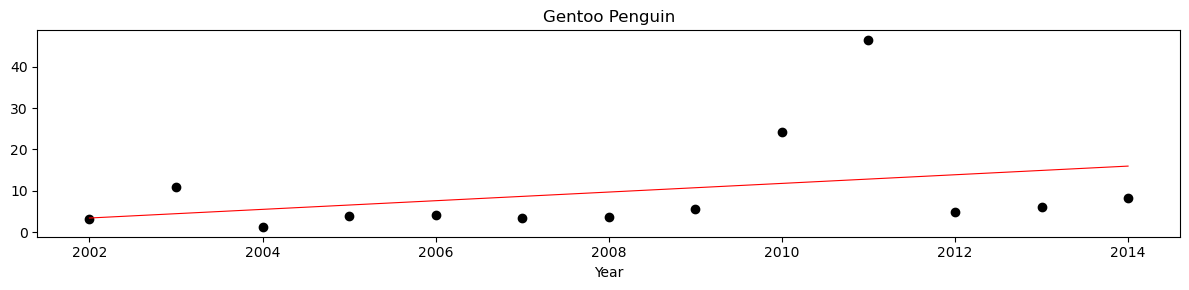

In [128]:
plot_yearly_species(df, 1, species)

- Chinstrap and Gentoo penguins show pretty similar patterns, adelie is only species where we would confidently say that the patterns are going up (specieswise)
- the 2010/2011 peak is from the cape shirreff colonies 

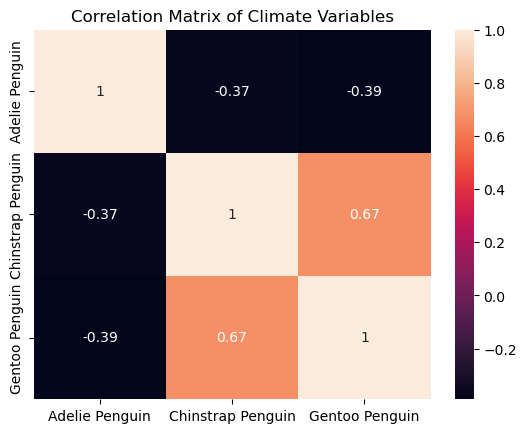

In [138]:
# correlations of species/years
species = df['common_name'].unique()
years = sorted(df['year'].unique())

df_new = pd.DataFrame()
df_new['year'] = years

df_new = pd.DataFrame({'year': years})  # Initialize with year column

for sp in species:
    grouped_data = df[df['common_name'] == sp].groupby('year')['km_to_colony'].mean()
    df_new[sp] = df_new['year'].map(grouped_data)

correlation_matrix = df_new[species].corr()

sns.heatmap(correlation_matrix, annot=True)
plt.title(f'Correlation Matrix of penguin travel pattern')
plt.show()

In [205]:
df_adelie = df[df['common_name'] == 'Adelie Penguin']

df_adelie = df_adelie.drop(columns=['delta_km_north',
       'delta_km_south', 'delta_km_east', 'delta_km_west',
       'minutes_since_last_measure', 'month', 'year', 'breed_stage_breeding',
       'breed_stage_brood-guard', 'breed_stage_chick-rearing',
       'breed_stage_creche', 'breed_stage_incubation',
       'breed_stage_non-breeding', 'breed_stage_winter', 'relative_position_E',
       'relative_position_N', 'relative_position_NE', 'relative_position_NW',
       'relative_position_S', 'relative_position_SE', 'relative_position_SW',
       'relative_position_W', 'direction_of_travel_E', 'direction_of_travel_N',
       'direction_of_travel_NE', 'direction_of_travel_NW',
       'direction_of_travel_S', 'direction_of_travel_SE',
       'direction_of_travel_SW', 'direction_of_travel_W'])


In [213]:
# average position for months (latitude and longitude)
months = [12, 1, 2]
df_adelie['month'] = df_adelie['date_gmt'].dt.month
df_adelie['year'] = df_adelie['date_gmt'].dt.year
df_adelie['day'] = df_adelie['date_gmt'].dt.day
for year in years:
    for month in months:
        df_month = df_adelie[(df_adelie['year'] == year) & (df_adelie['month'] == month)]

In [214]:
# check which years have more than 100 days of data
years = sorted(df_adelie['year'].unique())

# group by day
df_adelie = df_adelie.groupby(['year', 'month', 'day']).mean().reset_index()

print(df_adelie['year'].value_counts())

2013    143
2012    134
2014    113
2004    103
2016     56
2005     56
2003     53
1997     45
2017     44
2010     42
2002     34
2000     29
1996     25
1999     18
2011     11
2009     10
2001     10
2006     10
2007      4
Name: year, dtype: int64


/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_11747/2414832450.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_adelie = df_adelie.groupby(['year', 'month', 'day']).mean().reset_index()
